In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

In [4]:
adata_batch1=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.077.h5ad')
adata_batch1.var_names_make_unique()
adata_batch1.obs['batch']='MERFISH_-1.077'

adata_batch2=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.078.h5ad')
adata_batch2.var_names_make_unique()
adata_batch2.obs['batch']='MERFISH_-1.078'

In [5]:
adata_list=[adata_batch1,adata_batch2]
adata = ad.concat(adata_list, join="inner")
adata.obs['type']='Pre-training data'

In [6]:
adatas = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.scale(a)
    adatas.append(a)
adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X

In [7]:
graphs = []
for batch in adata.obs['batch'].unique():
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=16, device=device)
    graphs.append(graph)

all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

In [8]:
in_channels = graph.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.43it/s, Epoch=199, Loss=0.9217]


In [10]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [11]:
adata.obsm['SpaLP']=embedding

In [12]:
torch.save(model.state_dict(), "/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting6/77+78_pretrian_model.pth")

In [13]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting6/Pre-training.h5ad',compression='gzip')

In [14]:
from SpaLP.utils import transfer_labels_by_cosine

In [15]:
adata1=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.076.h5ad')
adata1.var_names_make_unique()
adata1.obs['type']='Inference data1'

In [16]:
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X

In [17]:
graph1 = prepare_inputs(adata1, k=16, device=device)

In [18]:
in_channels = graph1.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting6/77+78_pretrian_model.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph1.features, graph1.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

adata1.obsm['SpaLP']=embedding

In [19]:
Pre_train_data=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting6/Pre-training.h5ad')

In [20]:
Pre_train_data

AnnData object with n_obs × n_vars = 89361 × 1122
    obs: 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'cluster_id_transfer', 'subclass_transfer', 'cluster_confidence_score', 'subclass_confidence_score', 'high_quality_transfer', 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'slice', 'batch', 'type'
    obsm: 'SpaLP', 'X_CCF', 'X_spatial_coords', 'X_umap', 'feat', 'spatial'

In [21]:
adata1=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata1,label_key='major_brain_region',embedding_key='SpaLP')

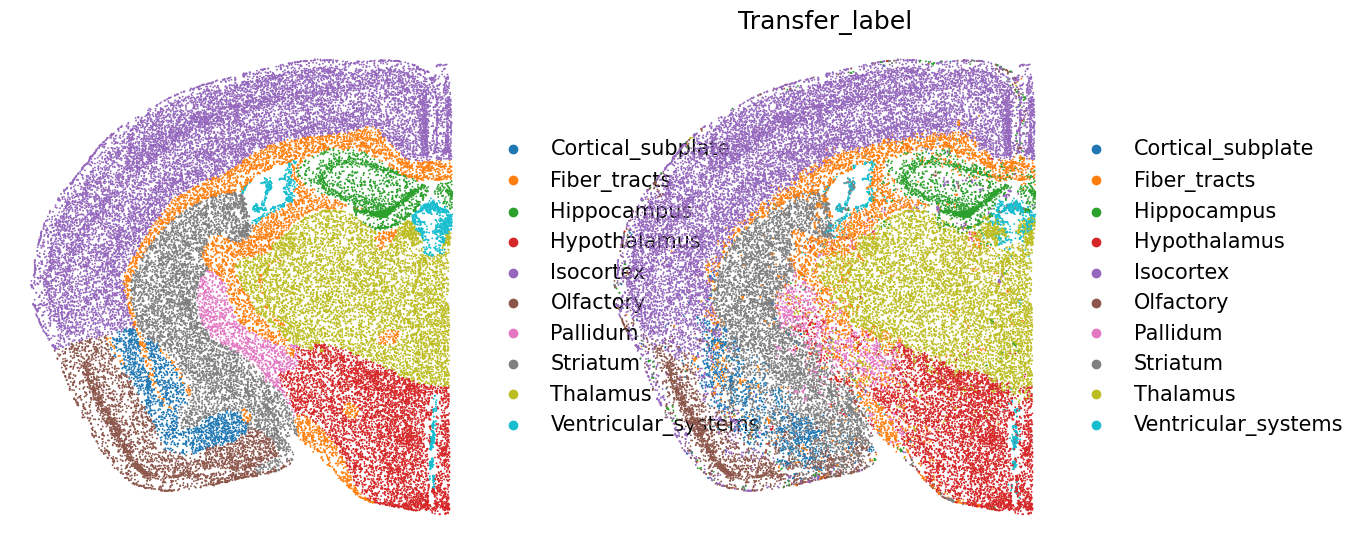

In [22]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata1, basis="spatial",s=7,color=['major_brain_region','Transfer_label'],colorbar_loc=None,title='',frameon=False)

In [23]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata1.obs['major_brain_region'])
cluster_labels = np.array(adata1.obs['Transfer_label'])

nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)

ARI: 0.7463014824279036
NMI: 0.6573289962196591


In [24]:
adata1.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting6/Transfer1.h5ad',compression='gzip')